# Train and Evaluate SqueezeNet on Cifar10 Dataset
*by Marvin Bertin*
<img src="../../images/keras-tensorflow-logo.jpg" width="400">

# Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

2023-07-24 15:44:19.348008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 15:44:19.456368: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-24 15:44:19.462882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:44:20.989174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
datasets = tf.keras.datasets
layers =  tf.keras.layers
models = tf.keras.models
losses = tf.keras.losses
optimizers = tf.keras.optimizers 
metrics = tf.keras.metrics
preprocessing_image = tf.keras.preprocessing.image
utils = tf.keras.utils
callbacks = tf.keras.callbacks

# Load Cifar10 Datset

In [3]:
(x_train, y_train), (x_test, y_test)= datasets.cifar10.load_data()

# Image Preprocessing and Augmentation

In [4]:
train_datagen = preprocessing_image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = preprocessing_image.ImageDataGenerator(rescale=1./255)

# One Hot Encoding of Target Vector

In [5]:
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)


# Data Generator

In [6]:
train_generator = train_datagen.flow(x=x_train, y=y_train, batch_size=32, shuffle=True)

test_generator = test_datagen.flow(x=x_test, y=y_test, batch_size=32, shuffle=True)

# SqueezeNet Model

In [7]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3

    x = layers.Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    left = layers.Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    right = layers.Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    x = layers.concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

def SqueezeNet(input_shape=(32,32,3), classes=10):

    img_input = layers.Input(shape=input_shape)


    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)
#     x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.5, name='drop9')(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)

    model = models.Model(img_input, out, name='squeezenet')

    return model

# Compile Model

In [8]:
def compile_model(model):
    
    # loss
    loss = losses.categorical_crossentropy
    
    # optimizer
    optimizer = optimizers.RMSprop(lr=0.0001)
    
    # metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    
    # compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)
    
    return model

# Train Model on Cifar10

In [9]:
sn = SqueezeNet()
sn = compile_model(sn)

In [10]:
history = sn.fit_generator(
    train_generator,
    steps_per_epoch=400,
    epochs=10,
    validation_data=test_generator,
    validation_steps=200)

Epoch 1/10


/tmp/ipykernel_10964/1905626917.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = sn.fit_generator(
2023-07-24 15:44:31.878429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


400/400 [==============================] - ETA: 0s - loss: 2.2161 - categorical_accuracy: 0.1521 - top_k_categorical_accuracy: 0.6721

2023-07-24 15:45:01.544897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


400/400 [==============================] - 33s 80ms/step - loss: 2.2161 - categorical_accuracy: 0.1521 - top_k_categorical_accuracy: 0.6721 - val_loss: 2.2179 - val_categorical_accuracy: 0.2067 - val_top_k_categorical_accuracy: 0.6995
Epoch 2/10
400/400 [==============================] - 24s 58ms/step - loss: 1.9968 - categorical_accuracy: 0.2532 - top_k_categorical_accuracy: 0.7884 - val_loss: 1.8723 - val_categorical_accuracy: 0.2958 - val_top_k_categorical_accuracy: 0.8238
Epoch 3/10
400/400 [==============================] - 23s 57ms/step - loss: 1.8563 - categorical_accuracy: 0.3016 - top_k_categorical_accuracy: 0.8391 - val_loss: 1.7250 - val_categorical_accuracy: 0.3400 - val_top_k_categorical_accuracy: 0.8755
Epoch 4/10
400/400 [==============================] - 23s 59ms/step - loss: 1.7257 - categorical_accuracy: 0.3510 - top_k_categorical_accuracy: 0.8716 - val_loss: 1.5846 - val_categorical_accuracy: 0.3964 - val_top_k_categorical_accuracy: 0.9003
Epoch 5/10
400/400 [=======

# Plot Accuracy and Loss Over Time

In [11]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

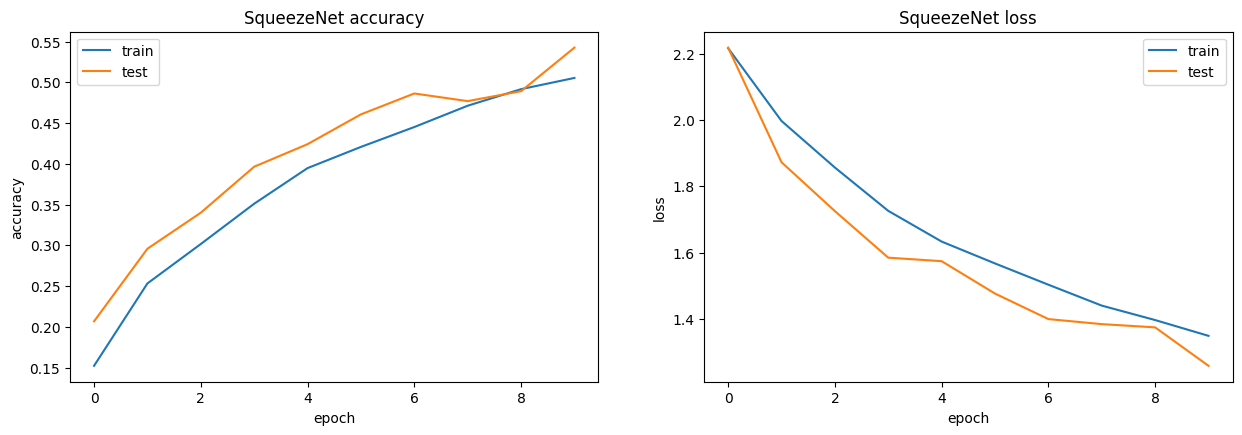

In [12]:
plot_accuracy_and_loss(history)

# Save Model Configuration and Weights

In [13]:
# save model architecture
model_json = sn.to_json()
open('squeeze_net_model.json', 'w').write(model_json)

# save model's learned weights
sn.save_weights('image_classifier_squeeze_net.h5', overwrite=True)

## Next Lesson
### ResNet: Residual Learning for Image Recognition


<img src="../../images/divider.png" width="100">